In [41]:
# import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [42]:
##########################################
##########HYPERPARAMS#####################
epochs = 5
learning_rate = 1e-3
batch_size = 128
seq_length = 8
log_interval = 1 #Log/show loss per batch
##########################################
##########################################

# Load MIDI files from npz

In [43]:
data = np.load('../YamahaPianoCompetition2002NoTranspose.npz')

midiDatasetTrain = data['train']
midiDatasetTest = data['test']

data.close()

"""
print("Training set: ({}, {}, {}, {})".format(midiDatasetTrain.size()[0],
                                                midiDatasetTrain.size()[1],
                                                midiDatasetTrain.size()[2],
                                                midiDatasetTrain.size()[3]))
print("Test set: ({}, {}, {}, {})".format(midiDatasetTest.size()[0],
                                                midiDatasetTest.size()[1],
                                                midiDatasetTest.size()[2],
                                                midiDatasetTest.size()[3]))
"""

print("Training set: {}".format(midiDatasetTrain.shape))
print("Test set: {}".format(midiDatasetTest.shape))

Training set: (39782, 1, 96, 60)
Test set: (9691, 1, 96, 60)


In [44]:
fullPitch = 128
_, _, length, reducedPitch = midiDatasetTrain.shape

In [45]:
#MODEL FOR TRANSFER LEARNING
from utils.VAE_Sigmoid import VAE
from loadModel import loadModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###VARIATIONAL CONV AUTOENCODER############
autoencoderModel = VAE()
pathToModel = '../models/YamahaPC2002_VAE_Reconstruct_NoTW_12Epochs_SigmoidEmbed100.model'
###########################################

autoencoderModel = loadModel(autoencoderModel, pathToModel, dataParallelModel=False)


--------GPU model restored--------



# CDVAE

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
midiDatasetTrain = torch.from_numpy(midiDatasetTrain)
trainLoader = torch.utils.data.DataLoader(midiDatasetTrain, batch_size=batch_size, shuffle=False, drop_last=True)

midiDatasetTest = torch.from_numpy(midiDatasetTest)
testLoader = torch.utils.data.DataLoader(midiDatasetTest, batch_size=batch_size, shuffle=False, drop_last=True)

In [48]:
class LSTM(nn.Module):
    def __init__(self, batch_size=7, lstm_layers=2, hidden_size=400, seq_length=7):
        super(LSTM, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.seq_length = seq_length
        
        ###LSTM###########
        self.lstm = nn.LSTM(input_size=100, hidden_size=self.hidden_size,
                            num_layers=self.lstm_layers, batch_first=True, dropout=0)
        ##################
        ###GRU############
        self.gru = nn.GRU(input_size=100, hidden_size=self.hidden_size, 
                          num_layers=self.lstm_layers, batch_first=True)
        ###LSTMCells######
        self.lstmC1 = nn.LSTMCell(input_size=100, hidden_size=self.hidden_size, bias=True)
        self.drop1 = nn.Dropout(p=0.2)
        self.lstmC2 = nn.LSTMCell(input_size=400, hidden_size=self.hidden_size, bias=True)
        self.drop2 = nn.Dropout(p=0.2)
        self.lstmC3 = nn.LSTMCell(input_size=400, hidden_size=self.hidden_size, bias=True)
        #################
        
        self.fc = nn.Linear(self.hidden_size,100)
        self.reluFC = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.leakyReLU = nn.LeakyReLU(0.1)
        self.tanh = nn.Tanh()
    
    def splitEmbedding(self, embed):     
        if(embed.size()[0]>self.seq_length):
            embedTemp = torch.chunk(embed, int(self.batch_size/self.seq_length),dim=0)
            embed7s = embedTemp[0].unsqueeze(0)
            for emb in embedTemp[1:]:
                #print("inloop");print(emb.unsqueeze(1).size())
                embed7s = torch.cat((embed7s, emb.unsqueeze(0)),dim=0)
                #print("afterconcat");print(embed7s.size())
        else:
            embed7s = embed.unsqueeze(1)
        return embed7s
    
    def hiddenInitLSTM(self,embed):
        hiddenState = torch.zeros(self.lstm_layers,embed.size()[0], self.hidden_size).double().to(device)
        cellState = torch.zeros(self.lstm_layers,embed.size()[0], self.hidden_size).double().to(device)
        return hiddenState,cellState
    
    def hiddenInitGRU(self,embed):
        hiddenState = torch.zeros(self.lstm_layers,embed.size()[0], self.hidden_size).to(device)    
        return hiddenState
    
    
    def hiddenInitLSTMCell(self):
        hiddenState = torch.zeros(int(self.batch_size/self.seq_length),
                                    self.hidden_size).double().to(device)
        cellState = torch.zeros(int(self.batch_size/self.seq_length),
                                    self.hidden_size).double().to(device)
        hS2 = torch.zeros(int(self.batch_size/self.seq_length),
                              self.hidden_size).double().to(device)
        cS2 = torch.zeros(int(self.batch_size/self.seq_length),
                              self.hidden_size).double().to(device)
        
        return (hiddenState, cellState), (hS2, cS2)

    def forward(self, embed, future = 0):#, lenghts):
        
        #embed = self.splitEmbedding(embed)
        #h_t, c_t = self.hiddenInitLSTM(embed)
        
        #h_t = self.hiddenInitGRU(embed)
        
        
        #embed = nn.utils.rnn.pack_padded_sequence(embed, 7, batch_first=True)
        (h_t, c_t),(h2_t, c2_t) = self.hiddenInitLSTMCell()
        #print(h_t.size())
        #print(h_t.size())
        ###LSTMCells######
        #print(embed.size())
        embedChunks = torch.chunk(embed, self.seq_length,dim=0)
        outputs = []
        for i, input_t in enumerate(embedChunks):
            h_t, c_t = self.lstmC1(input_t,(h_t, c_t))
            h2_t, c2_t = self.lstmC2(h_t,(h2_t, c2_t))
            output = self.fc(h2_t)
            outputs += [output]
        for i in range(future):
            h_t, c_t = self.lstmC1(output,(h_t, c_t))
            h2_t, c2_t = self.lstmC2(h_t, (h2_t, c2_t))
            output = self.fc(h2_t)
            outputs = [output]
        outputs = torch.stack(outputs, 1)
        #print(outputs.size())
        embedChunks = torch.stack(embedChunks,1)
        lstmOut = outputs
        """
        ###LSTM###########
        lstmOut, (h_t, c_t) = self.lstm(embed,(h_t, c_t))
        #lstmOut, h_t = self.gru(embed, h_t)
        ##################
        #lstmOut = self.reluFC(lstmOut)
        #lstmOut = self.sigmoid(lstmOut)
        lstmOut = self.tanh(lstmOut)
        #lstmOut = self.leakyReLU(lstmOut)
        
        lstmOut = self.fc(lstmOut)
        """
        if(self.training):
            print('embedding');print(embedChunks[0,6,:3])
            print('lstmOut');print(lstmOut[0,7,:3])
        
        #print('compare lstm ht');print(lstmOut.size());print(h_t.size())
        
        if(embed.size()[0]==7):
            embed = embed.squeeze(1)
        return embedChunks, lstmOut

    

model = LSTM(batch_size=batch_size, seq_length=seq_length).double().to(device)

#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-1)
optimizer = optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=0.9)

def loss_function(embed, lstmOut):
    
    batch_sizeMin1 = embed.size()[0]-1
    MSELoss = nn.MSELoss(reduction='elementwise_mean')
    BCELoss = nn.BCEWithLogitsLoss(reduction='sum')
    L1Loss = nn.L1Loss(reduction='sum')
    cosLoss = nn.CosineSimilarity(dim=1)
    #BATCHSIZE 7
    if(embed.size()[0]==7):
        print("loss");print(embed.size());print(lstmOut.size())
        lstmOut = torch.squeeze(lstmOut,1)
        mseLSTM = MSELoss(lstmOut[1:,:],embed[:-1,:])
        totalLoss =  mseLSTM / (embed.size()[1]*batch_sizeMin1)

    #BATCHSIZE > 7
    else:
        #print("LOSS");print(embed.size());print(lstmOut.size())
        
        mseLSTM = MSELoss(lstmOut[:,1:,:],embed[:,:-1,:])
        totalLoss = mseLSTM# / (embed.size()[0]*(embed.size()[1]-1)*embed.size()[2])
        
        #L1LSTM = L1Loss(lstmOut[:,:-1,:],embed[:,1:,:])
        #totalLoss = L1LSTM / (embed.size()[0]*(embed.size()[1]-1)*embed.size()[2])
        
        #cosSim = 0
        #for lOut, emb in zip(lstmOut, embed):
            #print(lOut[:-1,:].size());print(emb[1:,:].size())
            #cosSim += torch.sum(cosLoss(lOut[:-1,:],emb[1:,:]))
        #print(cosSim)
        #totalLoss = (embed.size()[0]*(embed.size()[1]-1)) - cosSim
        
        #BCELSTM = 0
        #for lOut, emb in zip(lstmOut,embed):
        #    BCELSTM += BCELoss(lOut[:-1,:],emb[1:,:])
        #totalLoss = BCELSTM / (embed.size()[0]*(embed.size()[1]-1))
        
        #CELoss = lstmLoss2(lstmOut[:,:-1,:],embed[:,1:,:])
        
        
    return totalLoss

def train(epoch):
    model.train()
    trainLoss = 0

    for batch_idx, data in enumerate(trainLoader):
        #print(batch_idx)
        data = data.float().to(device)
        optimizer.zero_grad()
        embedding, logvar = autoencoderModel.encoder(data)
        embedding = embedding.double()
        #print(embedding.size())
        embedding, lstmOut = model(embedding)
        
        loss = loss_function(embedding, lstmOut)
        
        ###LSTM###############
        #reconPrediction = autoencoderModel.decoder(lstmOut[-1,:,:])
        ######################
        ###LSTMCell###########
        #reconPrediction = autoencoderModel.decoder(lstmOut)
        ######################

        loss.backward()
        trainLoss += loss.item()
        optimizer.step()
        if(batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader),
                loss.item() / (len(data)-(model.batch_size/7))))
        #if(batch_idx==1):
        #   break
    print('====> Epoch: {} Average Loss: {:.4f}'.format(
          epoch, trainLoss / (len(trainLoader.dataset)-batch_idx*(model.batch_size/7))))

def test(epoch):
    model.eval()
    testLoss = 0
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            data = data.float().to(device)
            embedding, logvar = autoencoderModel.encoder(data)
            embedding = embedding.double()
            embedding, lstmOut = model(embedding)
            loss = loss_function(embedding, lstmOut)
            ###LSTM#########
            #reconPrediction = autoencoderModel.decoder(lstmOut[:,-1,:])
            ################
            ###LSTMCell#####
            #reconPrediction = autoencoderModel.decoder(lstmOut)
            ################
            testLoss += loss_function(embedding, lstmOut).item()
            
            #if(i==1):
            #    break
    testLoss /= (len(testLoader.dataset)-i*(model.batch_size/7))

    print('====> Test set Loss: {:.4f}'.format(testLoss))

In [49]:
"""
#LOAD MODEL
pathToModel = '../models/WikifoniaNoTranpose_10Epochs_LSTM_noTW_dropout50.model'

try:
    #LOAD TRAINED MODEL INTO GPU
    if(torch.cuda.is_available()):
        model = torch.load(pathToModel)
        
    #LOAD MODEL TRAINED ON GPU INTO CPU
    else:
        model = torch.load(pathToModel, map_location=lambda storage, loc: storage)
    print("\n--------model restored--------\n")
except:
    print("\n--------no saved model found--------\n")
"""
print('')

In [50]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

embedding
tensor([9.9911e-01, 2.3375e-38, 1.0000e+00],
       dtype=torch.float64, grad_fn=<SliceBackward>)
lstmOut
tensor([0.0653, 0.0964, 0.0072], dtype=torch.float64, grad_fn=<SliceBackward>)
Train Epoch: 1 [0/39782 (0%)]	Loss: 48.062585
embedding
tensor([1.7534e-13, 7.8725e-13, 1.0000e+00],
       dtype=torch.float64, grad_fn=<SliceBackward>)
lstmOut
tensor([0.8222, 1.0421, 0.7088], dtype=torch.float64, grad_fn=<SliceBackward>)
Train Epoch: 1 [128/39782 (0%)]	Loss: 30.872145
embedding
tensor([3.5034e-07, 1.0000e+00, 9.9914e-01],
       dtype=torch.float64, grad_fn=<SliceBackward>)
lstmOut
tensor([1.0266, 0.9857, 0.7820], dtype=torch.float64, grad_fn=<SliceBackward>)


KeyboardInterrupt: 

# LOAD LSTM

In [51]:
pathToModel = '../models/LSTM_YamahaPianoComp2002_20Epochs_MSE3.model'
###########################################

model = loadModel(model, pathToModel, dataParallelModel=False)


--------GPU model restored--------



In [52]:
#torch.save(model,'/media/EXTHD/niciData/models/YamahaPianoComp2002_5Epochs_LSTM_noTW.model')

In [ ]:
np.set_printoptions(precision=2, suppress=True, threshold=1)


(1, 96, 60)
(768, 128)
torch.Size([8, 1, 96, 60])
torch.Size([8, 100])
torch.Size([8, 100])
(96, 60)
(8, 96, 60)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
INPUT
(768, 128)


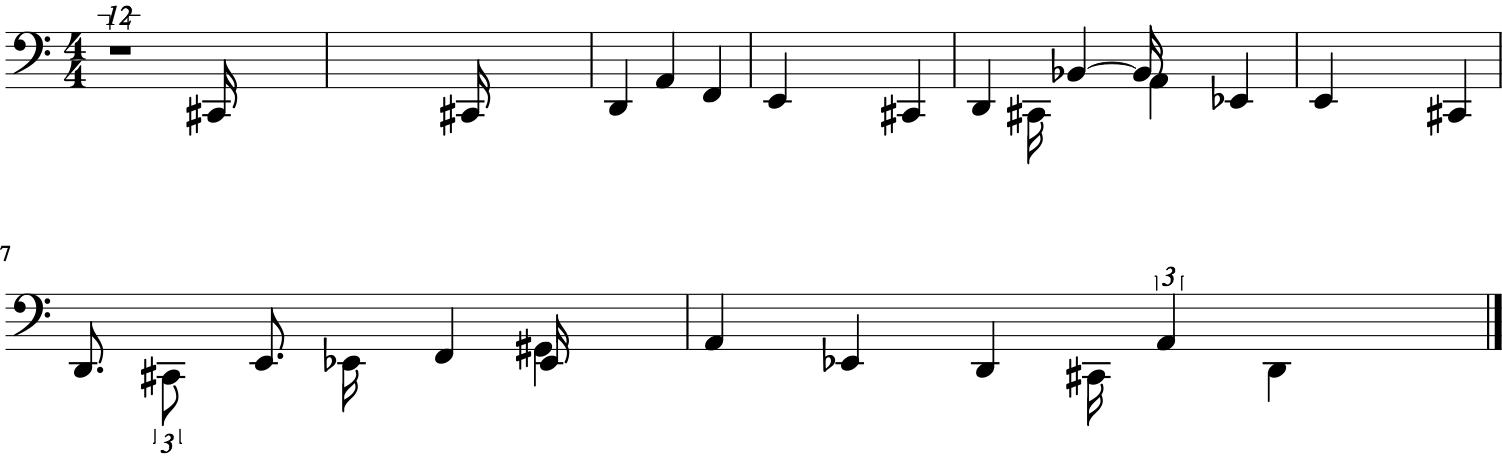

PREDICTION


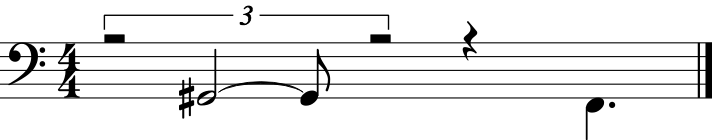

In [53]:
playSeq = 0
model.batch_size=8
pathToSampleSeq = "../DougMcKenzieFiles/train/Alone Together.mid"
if(model.train()):
    model.eval()
if(autoencoderModel.train()):
    autoencoderModel.eval()

###PREDICT 8th SEQUENCE
with torch.no_grad():
    
    sampleNp1 = getSlicedPianorollMatrixNp(pathToSampleSeq)
    sampleNp1 = deleteZeroMatrices(sampleNp1)
    sample = np.expand_dims(sampleNp1[0,:,36:-32],axis=0)
    print(sample.shape)
    for i, sampleNp in enumerate(sampleNp1[playSeq:playSeq+(seq_length-1)]):
        #print(sampleNp.shape)
        if(np.any(sampleNp)):
            sampleNp = sampleNp[:,36:-32]
            sampleNp = np.expand_dims(sampleNp,axis=0)
            sample = np.concatenate((sample,sampleNp),axis=0)
    samplePlay = sample[0,:,:]
    for s in sample[1:]:
        samplePlay = np.concatenate((samplePlay,s),axis=0)
    samplePlay = addCuttedOctaves(samplePlay)
    print(samplePlay.shape)
    #####PREPARE SAMPLE
    sample = torch.from_numpy(sample).float().to(device)
    sample = torch.unsqueeze(sample,1)
    print(sample.size())
    
    #####MODEL##############
    embed,logvar = autoencoderModel.encoder(sample)
    print(embed.size())
    embed = embed.double()
    #embed = model.splitEmbedding(embed)
    embed, lstmOut = model(embed)
    print(lstmOut[:,:,:].squeeze(0).size())
    lstmOut = lstmOut.float()
    pred = autoencoderModel.decoder(lstmOut[0,-1:,:])
    #pred = autoencoderModel.decoder(lstmOut[:,:,:].squeeze(1))
    ########################
    
    prediction = pred.squeeze(0).squeeze(0).cpu().numpy()
    print(prediction.shape)
    #predict = np.squeeze(prediction, axis=1)
    print(predict.shape)
    
    #####PLAY WHOLE LSTM OUT#############
    #prediction = predict[0,:,:]
    #print(prediction.shape)
    #for pred in predict[1:]:
    #    prediction = np.concatenate((prediction, pred), axis =0)
    #####################################
    #####PLAY NEXT SEQUENCE##############
    #prediction = predict[-1,:,:]
    #print(prediction.shape)
    #####################################
    #NORMALIZE PREDICTIONS
    #reconstruction /= np.abs(np.max(reconstruction))
    prediction /= np.abs(np.max(prediction))
    #print(prediction)

    #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
    #reconstruction[reconstruction < 0.3] = 0
    prediction[prediction < 0.3] = 0
    print(prediction)


    ###MONOPHONIC OUTPUT MATRIX POLOYPHONIC POSSIBLE WITH ACTIVATION THRESHOLD###
    #score = music21.converter.parse(
    #'WikifoniaServer/samples/The-Doors---Don\'t-you-love-her-Madly?.mid')
    #score.show()

    samplePlay = debinarizeMidi(samplePlay, prediction=False)
    samplePlay = addCuttedOctaves(samplePlay)
    #reconstruction = debinarizeMidi(reconstruction, prediction=True)
    #reconstruction = addCuttedOctaves(reconstruction)
    prediction = debinarizeMidi(prediction, prediction=True)
    prediction = addCuttedOctaves(prediction)
    print("INPUT")
    print(samplePlay.shape)
    pianorollMatrixToTempMidi(samplePlay, show=True,showPlayer=True,autoplay=True)
    #print("RECONSTRUCTION")
    #pianorollMatrixToTempMidi(reconstruction, show=True,
    #                            showPlayer=True,autoplay=True, prediction=True)
    print("PREDICTION")
    pianorollMatrixToTempMidi(prediction, prediction=True, 
                              show=True,showPlayer=True,autoplay=True)        
    print("\n\n")
            

print('')